In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!pip install mtcnn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 9.0 MB/s eta 0:00:00


In [6]:
import cv2 as cv
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
import pickle
from keras_facenet import FaceNet
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
from IPython.display import Image

In [7]:
img = cv.imread("/content/drive/MyDrive/mahasiswaTIP2/Desvita Nursayla Putri Cantika/1.jpg")
# opencv BGR channel format and plt reads images as RGB channel format

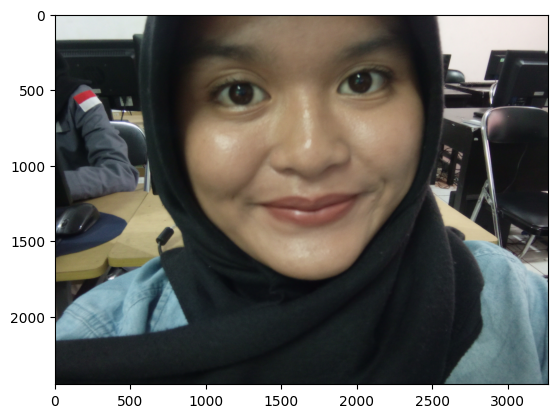

In [8]:
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
plt.imshow(img) # RGB

In [9]:
from mtcnn.mtcnn import MTCNN

detector = MTCNN()
results = detector.detect_faces(img)

In [ ]:
results

[{'box': [485, 729, 839, 1063],
  'confidence': 0.9995178580284119,
  'keypoints': {'left_eye': (702, 1139),
   'right_eye': (1091, 1098),
   'nose': (918, 1376),
   'mouth_left': (796, 1575),
   'mouth_right': (1101, 1543)}}]

In [10]:
x,y,w,h = results[0]['box']

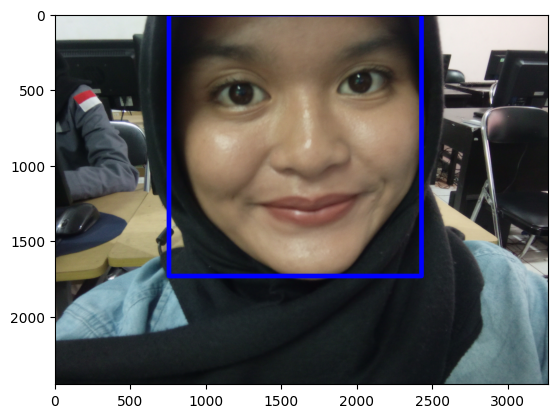

In [11]:
img = cv.rectangle(img, (x,y), (x+w, y+h), (0,0,255), 30)
plt.imshow(img)

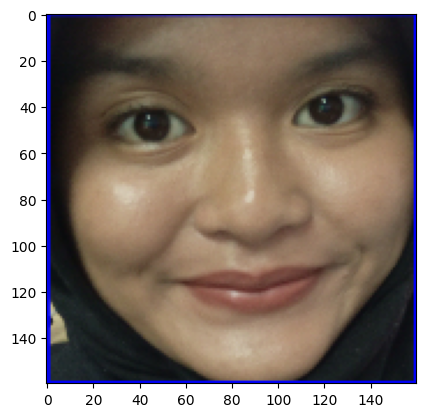

In [12]:
my_face = img[y:y+h, x:x+w]
#Facenet takes as input 160x160
my_face = cv.resize(my_face, (160,160))
plt.imshow(my_face)

array([[[  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255],
        ...,
        [  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255]],

       [[  0,   0, 255],
        [  3,   3, 225],
        [ 14,  17,  83],
        ...,
        [ 24,  21,  89],
        [ 22,  21,  87],
        [  0,   0, 255]],

       [[  0,   0, 255],
        [  3,   4, 216],
        [ 18,  23,  27],
        ...,
        [ 29,  28,  33],
        [ 28,  29,  31],
        [  0,   0, 255]],

       ...,

       [[  0,   0, 255],
        [  5,   7, 218],
        [ 33,  43,  47],
        ...,
        [ 21,  26,  28],
        [ 22,  28,  28],
        [  0,   0, 255]],

       [[  0,   0, 255],
        [  6,   7, 219],
        [ 34,  45,  45],
        ...,
        [ 18,  28,  27],
        [ 19,  25,  25],
        [  0,   0, 255]],

       [[  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255],
        ...,
        [  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255]]], dtype=uint8)
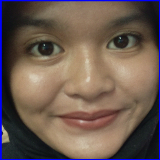

In [13]:
my_face

# Automate the preprocessing


In [14]:
class FACELOADING:
    def __init__(self, directory):
        self.directory = directory
        self.target_size = (160,160)
        self.X = []
        self.Y = []
        self.detector = MTCNN()


    def extract_face(self, filename):
        img = cv.imread(filename)
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        x,y,w,h = self.detector.detect_faces(img)[0]['box']
        x,y = abs(x), abs(y)
        face = img[y:y+h, x:x+w]
        face_arr = cv.resize(face, self.target_size)
        return face_arr


    def load_faces(self, dir):
        FACES = []
        for im_name in os.listdir(dir):
            try:
                path = dir + im_name
                single_face = self.extract_face(path)
                FACES.append(single_face)
            except Exception as e:
                pass
        return FACES

    def load_classes(self):
        for sub_dir in os.listdir(self.directory):
            path = self.directory +'/'+ sub_dir+'/'
            FACES = self.load_faces(path)
            labels = [sub_dir for _ in range(len(FACES))]
            print(f"Loaded successfully: {len(labels)}")
            self.X.extend(FACES)
            self.Y.extend(labels)

        return np.asarray(self.X), np.asarray(self.Y)


    def plot_images(self):
        plt.figure(figsize=(18,16))
        for num,image in enumerate(self.X):
            ncols = 3
            nrows = len(self.Y)//ncols + 1
            plt.subplot(nrows,ncols,num+1)
            plt.imshow(image)
            plt.axis('off')

In [16]:
faceloading = FACELOADING("/content/drive/MyDrive/mahasiswaTIP2")
X, Y = faceloading.load_classes()

Loaded successfully: 1
Loaded successfully: 1
Loaded successfully: 1
Loaded successfully: 1
Loaded successfully: 1


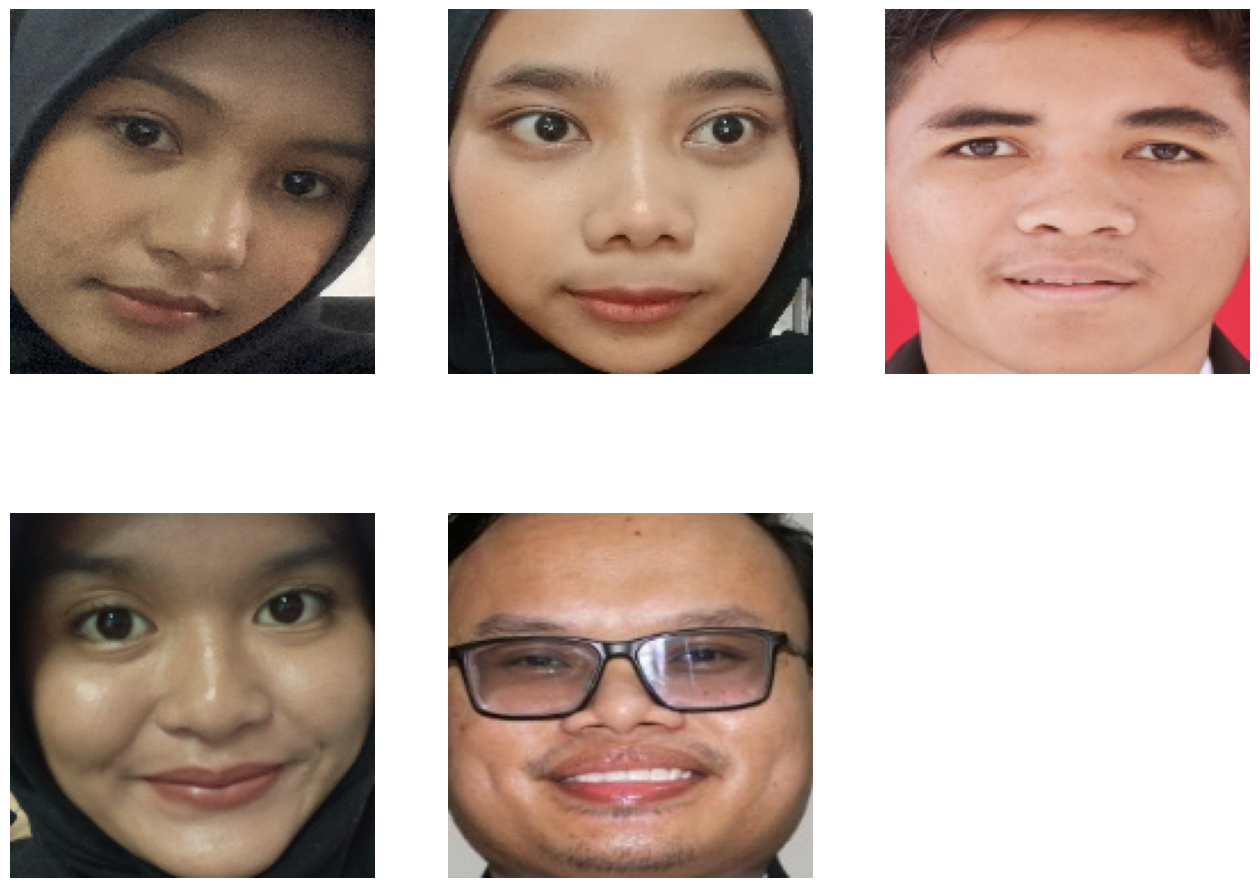

In [17]:
plt.figure(figsize=(16,12))
for num,image in enumerate(X):
    ncols = 3
    nrows = len(Y)//ncols + 1
    plt.subplot(nrows,ncols,num+1)
    plt.imshow(image)
    plt.axis('off')

# FaceNet part

In [5]:
!pip install keras-facenet

  Preparing metadata (setup.py) ... done
  Created wheel for keras-facenet: filename=keras_facenet-0.3.2-py3-none-any.whl size=10367 sha256=561e3ad5f4ef7a9b9f73df8936e601e1d3867aaa4b7863aa3e7518f6aade2ec3
  Stored in directory: /root/.cache/pip/wheels/99/94/dd/cb1a65a7440ba6d508bd24346c15af0b1d24ff8b1cdb1c9959
Successfully built keras-facenet


In [18]:
from keras_facenet import FaceNet
embedder = FaceNet()

def get_embedding(face_img):
    face_img = face_img.astype('float32') # 3D(160x160x3)
    face_img = np.expand_dims(face_img, axis=0)
    # 4D (Nonex160x160x3)
    yhat= embedder.embeddings(face_img)
    return yhat[0] # 512D image (1x1x512)

In [19]:
EMBEDDED_X = []

for img in X:
    EMBEDDED_X.append(get_embedding(img))

EMBEDDED_X = np.asarray(EMBEDDED_X)

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


In [20]:
np.savez_compressed('faces_embeddings_done_4classes.npz', EMBEDDED_X, Y)

# SVM model


In [21]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
encoder.fit(Y)
Y = encoder.transform(Y)

Text(0, 0.5, '3')

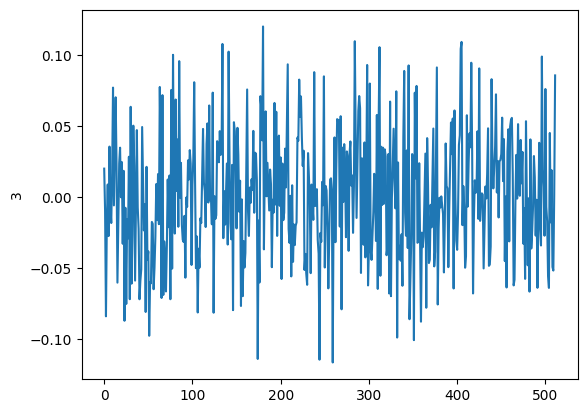

In [22]:
plt.plot(EMBEDDED_X[0])
plt.ylabel(Y[0])

In [23]:
break

SyntaxError: 'break' outside loop (ipython-input-23-668683560.py, line 1)

In [24]:
Y

array([3, 4, 1, 0, 2])

In [25]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(EMBEDDED_X, Y, shuffle=True, random_state=17)

In [26]:
from sklearn.svm import SVC
model = SVC(kernel='linear', probability=True)
model.fit(X_train, Y_train)

SVC(kernel='linear', probability=True)

In [27]:
ypreds_train = model.predict(X_train)
ypreds_test = model.predict(X_test)

In [28]:
from sklearn.metrics import accuracy_score

accuracy_score(Y_train, ypreds_train)

1.0

In [29]:
accuracy_score(Y_test,ypreds_test)

0.0

In [30]:
t_im = cv.imread("/content/drive/MyDrive/mahasiswaTIP2/Desvita Nursayla Putri Cantika/1.jpg")
t_im = cv.cvtColor(t_im, cv.COLOR_BGR2RGB)
x,y,w,h = detector.detect_faces(t_im)[0]['box']

In [31]:
t_im = t_im[y:y+h, x:x+w]
t_im = cv.resize(t_im, (160,160))
test_im = get_embedding(t_im)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


In [32]:
test_im = [test_im]
ypreds = model.predict(test_im)

In [33]:
ypreds

array([0])

In [34]:
encoder.inverse_transform(ypreds)

array(['Desvita Nursayla Putri Cantika'], dtype='<U30')

In [35]:
import pickle
#save the model
with open('svm_model_160x160.pkl','wb') as f:
    pickle.dump(model,f)

In [44]:
#INITIALIZE
facenet = FaceNet()
faces_embeddings = np.load("faces_embeddings_done_4classes.npz")
Y = faces_embeddings['arr_1']
encoder = LabelEncoder()
encoder.fit(Y)
# Download the haarcascade XML file
!wget https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml -P /content/
haarcascade = cv.CascadeClassifier("/content/haarcascade_frontalface_default.xml")
model = pickle.load(open("svm_model_160x160.pkl", 'rb'))

--2025-07-03 08:02:18--  https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 930127 (908K) [text/plain]
Saving to: ‘/content/haarcascade_frontalface_default.xml’

haarcascade_frontal 100%[===================>] 908.33K  --.-KB/s    in 0.04s   

2025-07-03 08:02:19 (22.1 MB/s) - ‘/content/haarcascade_frontalface_default.xml’ saved [930127/930127]



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


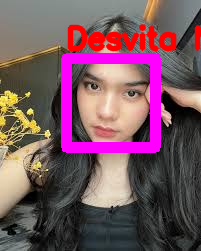

In [53]:
from google.colab.patches import cv2_imshow
import cv2 as cv2 # import cv2 here
image = cv2.imread("/content/davina.jpg")
rgb_img = cv.cvtColor(image, cv.COLOR_BGR2RGB)
gray_img = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
faces = haarcascade.detectMultiScale(gray_img, 1.3, 5)
for x,y,w,h in faces:
    img = rgb_img[y:y+h, x:x+w]
    img = cv.resize(img, (160,160)) # 1x160x160x3
    img = np.expand_dims(img,axis=0)
    ypred = facenet.embeddings(img)
    face_name = model.predict(ypred)
    final_name = encoder.inverse_transform(face_name)[0]
    cv.rectangle(image, (x,y), (x+w,y+h), (255,0,255), 10)
    cv.putText(image, str(final_name), (x,y-10), cv.FONT_HERSHEY_SIMPLEX,
               1, (0,0,255), 3, cv.LINE_AA)
cv2_imshow(image)

In [38]:
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

In [39]:
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)

  # get photo data
  data = eval_js('takePhoto({})'.format(quality))
  # get OpenCV format image
  imgg = js_to_image(data)

  rgb_img = cv.cvtColor(imgg, cv.COLOR_BGR2RGB)
  gray_img = cv.cvtColor(imgg, cv.COLOR_BGR2GRAY)
  faces = haarcascade.detectMultiScale(gray_img, 1.3, 5)
  for x,y,w,h in faces:
      img = rgb_img[y:y+h, x:x+w]
      img = cv.resize(img, (160,160)) # 1x160x160x3
      img = np.expand_dims(img,axis=0)
      ypred = facenet.embeddings(img)
      face_name = model.predict(ypred)
      final_name = encoder.inverse_transform(face_name)[0]
      cv.rectangle(imgg, (x,y), (x+w,y+h), (255,0,255), 10)
      cv.putText(imgg, str(final_name), (x,y-10), cv.FONT_HERSHEY_SIMPLEX,
                 1, (0,0,255), 3, cv.LINE_AA)
  # save image
  cv2.imwrite(filename, imgg)
  return filename

In [54]:
try:
  filename = take_photo('photo.jpg')
  print('Saved to {}'.format(filename))

  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

<IPython.core.display.Javascript object>

NotFoundError: Requested device not found


# Task
Explain the error in the selected code. If possible, fix the error and incorporate the changes into the existing code. Otherwise, try to diagnose the error.

## Download haar cascade file

### Subtask:
Download the `haarcascade_frontalface_default.xml` file needed for face detection.


**Reasoning**:
The subtask is to download the haarcascade file. I will use `wget` to download the file from the OpenCV GitHub repository.

